### 5.1 PCA

In [1]:
import pandas as pd
df_wine = pd.read_csv(
    'https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data',header=None)

In [2]:
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler

X, y = df_wine.iloc[:,1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=0)

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std  = sc.transform(X_test)

C:\Users\yueki\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
# 5.1.2 Caculate eigenvalue & eigenvector
import numpy as np
cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

print('/nEigenvalues \n%s' % eigen_vals)

/nEigenvalues 
[4.84274532 2.41602459 1.54845825 0.96120438 0.84166161 0.6620634
 0.51828472 0.34650377 0.3131368  0.10754642 0.21357215 0.15362835
 0.1808613 ]


In [4]:
%matplotlib inline

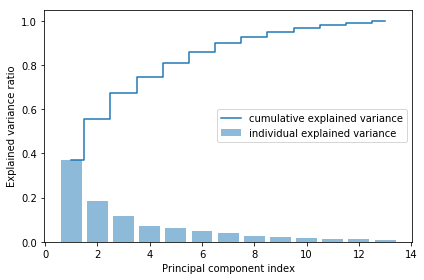

In [5]:
# 5.1.3
tot = sum(eigen_vals)
var_exp = [( i / tot) for i in sorted(eigen_vals, reverse=True)]

cum_var_exp = np.cumsum(var_exp)
import matplotlib.pyplot as plt

plt.bar(range(1,14), var_exp, alpha=0.5, align='center',
       label='individual explained variance')

plt.step(range(1,14),cum_var_exp, where='mid',
        label='cumulative explained variance')

plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [6]:
#$ 5.1.4 Feature transformation

eigen_pairs = [(np.abs(eigen_vals[i]),eigen_vecs[:,i])
                for i in range(len(eigen_vals))]
eigen_pairs.sort(key=lambda k: k[0], reverse=True)
w = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))
print('Matrix W::\n',w)


Matrix W::
 [[-0.13724218  0.50303478]
 [ 0.24724326  0.16487119]
 [-0.02545159  0.24456476]
 [ 0.20694508 -0.11352904]
 [-0.15436582  0.28974518]
 [-0.39376952  0.05080104]
 [-0.41735106 -0.02287338]
 [ 0.30572896  0.09048885]
 [-0.30668347  0.00835233]
 [ 0.07554066  0.54977581]
 [-0.32613263 -0.20716433]
 [-0.36861022 -0.24902536]
 [-0.29669651  0.38022942]]


In [7]:
X_train_std[0].dot(w)

array([2.38299011, 0.45458499])

In [8]:
X_train_pca = X_train_std.dot(w)

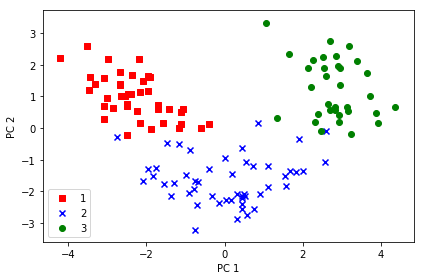

In [9]:
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train==l, 0],
                X_train_pca[y_train==l, 1],
               c=c, label=l, marker=m)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()
    

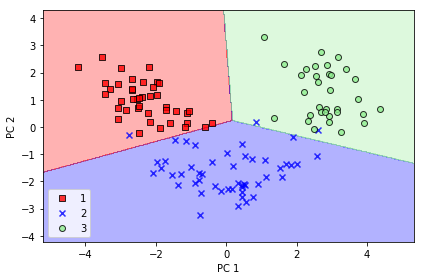

In [10]:
# 5.1.5 Principal component analysis in scikit-learn

# import method defined in chap2
from _tools import plot_decision_regions

from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

lr = LogisticRegression()

X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

lr.fit(X_train_pca, y_train)

plot_decision_regions(X_train_pca, y_train, classifier=lr)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

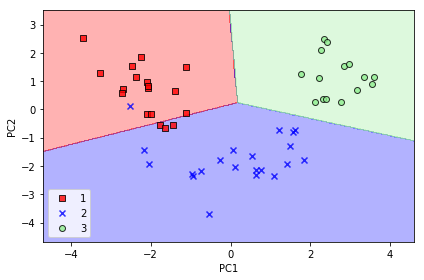

In [11]:
plot_decision_regions(X_test_pca, y_test,classifier=lr)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

In [12]:
pca = PCA(n_components=None)
X_train_pca = pca.fit_transform(X_train_std)

pca.explained_variance_ratio_

array([0.36951469, 0.18434927, 0.11815159, 0.07334252, 0.06422108,
       0.05051724, 0.03954654, 0.02643918, 0.02389319, 0.01629614,
       0.01380021, 0.01172226, 0.00820609])

### 5.2 LDA

#### 5.2.3 Calculate scatter matrix

In [13]:
np.set_printoptions(precision=4)
mean_vecs = []
for label in range(1,4):
    mean_vecs.append(np.mean(X_train_std[y_train==label],axis=0))
    print('MV %s: %s\n' %(label,mean_vecs[label-1]))

MV 1: [ 0.9066 -0.3497  0.3201 -0.7189  0.5056  0.8807  0.9589 -0.5516  0.5416
  0.2338  0.5897  0.6563  1.2075]

MV 2: [-0.8749 -0.2848 -0.3735  0.3157 -0.3848 -0.0433  0.0635 -0.0946  0.0703
 -0.8286  0.3144  0.3608 -0.7253]

MV 3: [ 0.1992  0.866   0.1682  0.4148 -0.0451 -1.0286 -1.2876  0.8287 -0.7795
  0.9649 -1.209  -1.3622 -0.4013]



In [14]:
d = 13 # character num
S_W = np.zeros((d, d))
for label,mv in zip(range(1,4), mean_vecs):
    class_scatter = np.zeros((d, d))
    for row in X_train_std[y_train == label]:
        row, mv = row.reshape(d,1), mv.reshape(d,1)
        class_scatter += (row - mv).dot((row - mv).T)
        S_W += class_scatter
print('Within-class scatter matrix: %sx%s' % (S_W.shape[0], S_W.shape[1]))     

Within-class scatter matrix: 13x13


In [15]:
mean_overall = np.mean(X_train_std, axis=0)
d = 13
S_B = np.zeros((d, d))
for i, mean_vec  in enumerate(mean_vecs):
    n = X_train[y_train == i + 1, :].shape[0]
    
    mean_vec = mean_vec.reshape(d, 1)
    mean_overall = mean_overall.reshape(d, 1)
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)
print('Between-class scatter matrix: %sx%s' % (S_B.shape[0], S_B.shape[1]))

Between-class scatter matrix: 13x13


In [16]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
              for i in range(len(eigen_vals))]

eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)
print('Eigenvalues in descending order:\n')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

Eigenvalues in descending order:

0.4190441115034062
0.19673290564476184
6.490794717846114e-17
3.170566999301108e-17
3.170566999301108e-17
3.0247612577021183e-17
2.4210247294590214e-17
2.4210247294590214e-17
2.0796794809052003e-17
1.507520868083642e-17
6.560589268345932e-18
6.560589268345932e-18
0.0


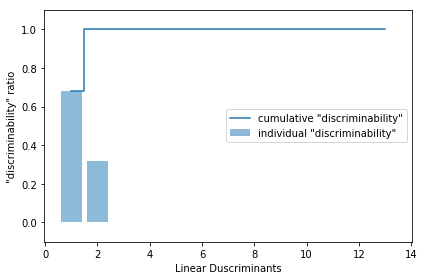

In [17]:
tot = sum(eigen_vals.real)
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)
plt.bar(range(1,14), discr, alpha=0.5, align='center',
       label='individual "discriminability"')
plt.step(range(1,14), cum_discr, where='mid',
        label='cumulative "discriminability"')
plt.ylabel('"discriminability" ratio')
plt.xlabel('Linear Duscriminants')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [18]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real,
              eigen_pairs[1][1][:, np.newaxis].real))

print('Matrix W:\n', w)

Matrix W:
 [[-0.1497 -0.3246]
 [ 0.064  -0.1482]
 [ 0.0169 -0.3136]
 [ 0.1269  0.2537]
 [-0.0495 -0.0227]
 [ 0.2168 -0.1613]
 [-0.7542  0.4865]
 [-0.1321  0.0371]
 [ 0.0507  0.0127]
 [ 0.3038 -0.3411]
 [-0.0009  0.1639]
 [-0.2212  0.0953]
 [-0.4214 -0.5413]]


#### 5.2.5

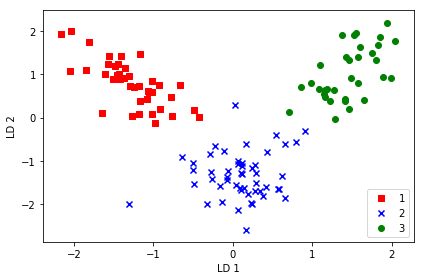

In [19]:
X_train_lda = X_train_std.dot(w)
colors= ['r''','b','g']
markers = ['s','x','o']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train == l, 0],
                X_train_lda[y_train == l, 1] * (-1),
                c=c, label=l, marker=m)
plt.xlabel(('LD 1'))
plt.ylabel(('LD 2'))
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

#### 5.2.6 LDA in scikit-learn


In [20]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)

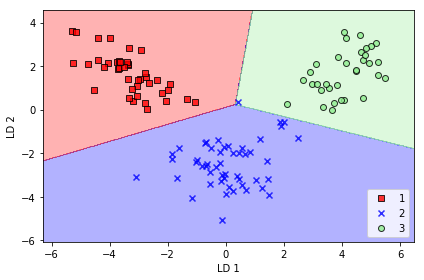

In [21]:
lr = LogisticRegression()
lr = lr.fit(X_train_lda, y_train)
plot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.xlabel(('LD 1'))
plt.ylabel(('LD 2'))
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


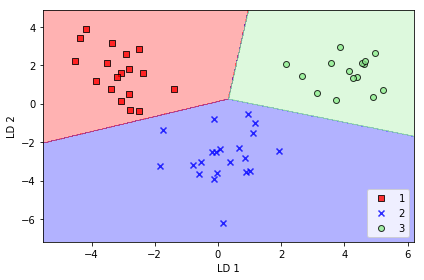

In [22]:
X_test_lda = lda.transform(X_test_std)
plot_decision_regions(X_test_lda, y_test, classifier=lr)
plt.xlabel(('LD 1'))
plt.ylabel(('LD 2'))
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


### 5.3 Kernel

In [55]:
from scipy.spatial.distance import pdist, squareform
from scipy import exp
from scipy.linalg import eigh
import numpy as np

def rbf_kernel_pca(X, gamma, n_components):
    """
    Parameters
    -------------------------
    X: {numpy ndarray} ,shape = {n_samples, n_features}
    
    gamma: float
    Tuning para of RBF Kernel
    
    n_components: int
        number of main features
    
    Return
    -------------------------
    x_pc:  {numpy ndarray} ,shape = {n_samples, k_features}
    projected dataset
    
    """
    
    sq_dists = pdist(X, 'sqeuclidean')
    mat_sq_dists = squareform(sq_dists)
    
    # 1. compute Kernel matrix
    K = exp(-gamma* mat_sq_dists)
    
    # 2. Centrarize Kernel matrix
    N = K.shape[0]
    one_n = np.ones((N,N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)
    
    # eigval
    eigvals, eigvecs = eigh(K)
    eigvals, eigvecs = eigvals[::-1], eigvecs[:, ::-1]
    
    # projected eigvals
    X_pc = np.column_stack((eigvecs[:,i] for i in range(n_components)))
    
    return X_pc

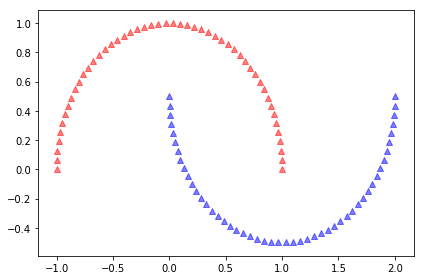

In [33]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, random_state=123)
plt.scatter(X[y==0, 0], X[y==0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', marker='^', alpha=0.5)
plt.tight_layout()
plt.show()

#### Standard PCA

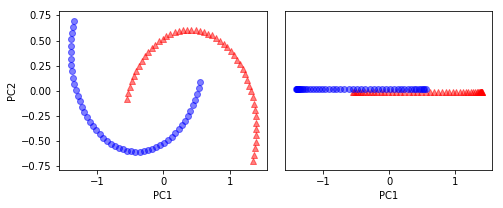

In [50]:
from sklearn.decomposition import PCA
scikit_pca = PCA(n_components=2)

X_spca = scikit_pca.fit_transform(X)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7,3))

ax[0].scatter(X_spca[y==0, 0], X_spca[y==0, 1],
             color='red' , marker='^', alpha=0.5)
ax[0].scatter(X_spca[y==1, 0], X_spca[y==1, 1],
             color='blue', marker='o', alpha=0.5)
ax[1].scatter(X_spca[y==0, 0], np.zeros((50, 1))+0.02,
             color='red' , marker='^', alpha=0.5)
ax[1].scatter(X_spca[y==1, 0], np.zeros((50, 1))-0.02,
             color='blue' , marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([1,-1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')
plt.tight_layout()
plt.show()

#### Kernel PCS

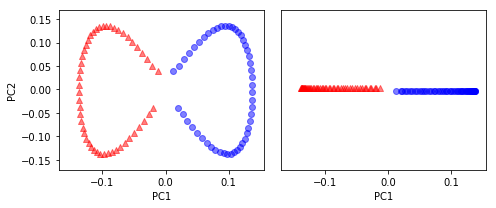

In [64]:
from matplotlib.ticker import FormatStrFormatter

X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(7,3))

ax[0].scatter(X_kpca[y==0, 0], X_kpca[y==0, 1],
             color='red' , marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y==1, 0], X_kpca[y==1, 1],
             color='blue', marker='o', alpha=0.5)
ax[1].scatter(X_kpca[y==0, 0], np.zeros((50, 1))+0.02,
             color='red' , marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y==1, 0], np.zeros((50, 1))-0.02,
             color='blue' , marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1,1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')
plt.tight_layout()
plt.show()

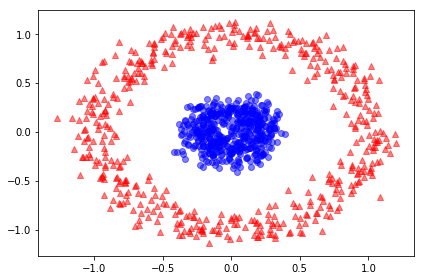

In [72]:
#### Sample 2

from sklearn.datasets import make_circles
X, y = make_circles(n_samples=1000,random_state=123,noise=0.1, factor=0.2)
plt.scatter(X[y==0, 0], X[y==0, 1], color='red' , marker='^', alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', marker='o', alpha=0.5)
plt.tight_layout()
plt.show()

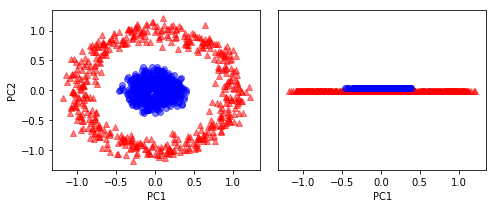

In [75]:
scikit_sca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7,3))
ax[0].scatter(X_spca[y==0, 0], X_spca[y==0, 1],
             color='red' , marker='^', alpha=0.5)
ax[0].scatter(X_spca[y==1, 0], X_spca[y==1, 1],
             color='blue', marker='o', alpha=0.5)
ax[1].scatter(X_spca[y==0, 0], np.zeros((500, 1))+0.02,
             color='red' , marker='^', alpha=0.5)
ax[1].scatter(X_spca[y==1, 0], np.zeros((500, 1))-0.02,
             color='blue' , marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([1,-1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')
plt.tight_layout()
plt.show()

#### Kernel PCA

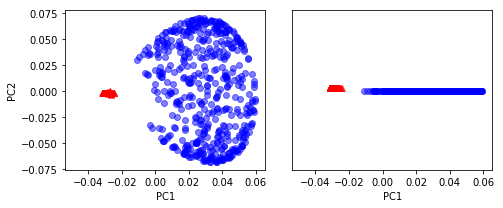

In [76]:
X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(7,3))

ax[0].scatter(X_kpca[y==0, 0], X_kpca[y==0, 1],
             color='red' , marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y==1, 0], X_kpca[y==1, 1],
             color='blue', marker='o', alpha=0.5)
ax[1].scatter(X_kpca[y==0, 0], np.zeros((500, 1))+0.02,
             color='red' , marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y==1, 0], np.zeros((500, 1))-0.02,
             color='blue' , marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1,1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')
plt.tight_layout()
plt.show()

#### 5.3.3

In [82]:
from scipy.spatial.distance import pdist, squareform
from scipy import exp
from scipy.linalg import eigh
import numpy as np

def rbf_kernel_pca2(X, gamma, n_components):
    """
    Parameters
    -------------------------
    X: {numpy ndarray} ,shape = {n_samples, n_features}
    
    gamma: float
    Tuning para of RBF Kernel
    
    n_components: int
        number of main features
    
    Return
    -------------------------
    x_pc:  {numpy ndarray} ,shape = {n_samples, k_features}
    projected dataset
    
    lambdas: list
    """
    
    sq_dists = pdist(X, 'sqeuclidean')
    mat_sq_dists = squareform(sq_dists)
    
    # 1. compute Kernel matrix
    K = exp(-gamma* mat_sq_dists)
    
    # 2. Centrarize Kernel matrix
    N = K.shape[0]
    one_n = np.ones((N,N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)
    
    # eigval
    eigvals, eigvecs = eigh(K)
    eigvals, eigvecs = eigvals[::-1], eigvecs[:, ::-1]
    
    
    # Modified 
    alphas = np.column_stack((eigvecs[:, i]
                             for i in range(n_components)))
    lambdas = [eigvals[i] for i in range(n_components)]
    
    # projected eigvals
    #X_pc = np.column_stack((eigvecs[:,i] for i in range(n_components)))
    
    
    return alphas, lambdas

In [83]:
X, y = make_moons(n_samples=100, random_state=123)
alphas , lambdas = rbf_kernel_pca2(X, gamma=15, n_components=1)

In [90]:
# New entry
x_new = X[25]
x_new

array([1.8713, 0.0093])

In [91]:
x_proj = alphas[25]
x_proj

array([0.0788])

In [92]:
def project_x(x_new, X, gamma,alphas, lambdas):
    pair_dist = np.array([np.sum((x_new-row)**2) for row in X])
    k = np.exp(-gamma * pair_dist)
    return k.dot(alphas / lambdas)

In [95]:
x_reproj = project_x(x_new, X, gamma=15, alphas=alphas, lambdas=lambdas)
x_reproj

array([0.0788])

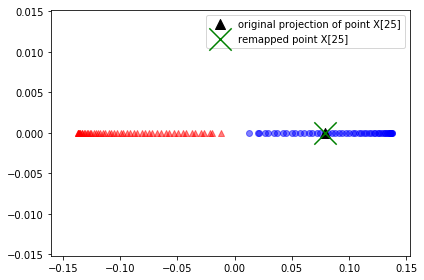

In [103]:
plt.scatter(alphas[y==0, 0], np.zeros((50)), color='red' , marker='^', alpha=0.5)
plt.scatter(alphas[y==1, 0], np.zeros((50)), color='blue', marker='o', alpha=0.5)
plt.scatter(x_proj, 0, color='black', label='original projection of point X[25]',marker='^', s= 100)
plt.scatter(x_reproj, 0, color='green', label='remapped point X[25]',
            marker='x', s=500)
plt.legend(scatterpoints=1)
plt.tight_layout()
plt.show()

#### 5.3.4

In [108]:
from sklearn.decomposition import KernelPCA
X, y = make_moons(n_samples=100, random_state=123)
scikit_kpca = KernelPCA(n_components=2,kernel='rbf', gamma=15)
X_skernpca = scikit_kpca.fit_transform(X)

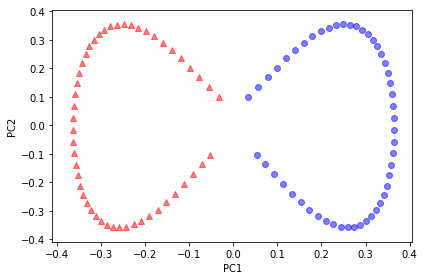

In [111]:
plt.scatter(X_skernpca[y==0, 0], X_skernpca[y==0,1],
           color='red', marker='^', alpha=0.5)
plt.scatter(X_skernpca[y==1, 0], X_skernpca[y==1,1],
           color='blue', marker='o',alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.show()